In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import math
from sklearn.model_selection import KFold

from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

from sklearn.manifold import TSNE

import learning_utils as lu
import random
import scipy.stats as st
import datetime

double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

now=datetime.datetime.today()

seen_df = (347, 8)
unseen_df = (5774, 8)
df = (6121, 8)


Text(0, 0.5, 'Number of documents')

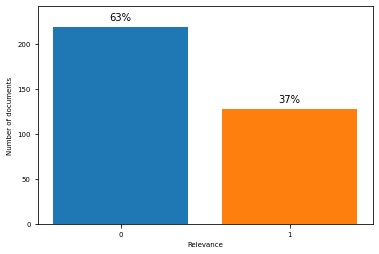

In [12]:
#seen_df = pd.DataFrame(columns=['id','content','title','PY','wosarticle__de','wosarticle__wc','relevent','seen'])
temp=pd.read_csv('seen_df.csv')
seen_df = temp
print ("seen_df =",seen_df.shape)
temp=pd.read_csv('unseen_df.csv')
unseen_df = temp
print ("unseen_df =",unseen_df.shape)

df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

print ("df =",df.shape)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

temp=pd.read_csv('gudf.csv') 
gudf=temp

df = pd.merge(df, gudf.rename(columns={"doc__id":"id"}), how="left").fillna(0)

fig, ax = plt.subplots()
n = seen_df.shape[0]
y = df['relevant']
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

ax.set_xticks([0,1])
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xlabel('Relevance')
ax.set_ylabel('Number of documents')


In [13]:
import pickle
import scipy
revectorize = True
y = df['relevant']
if revectorize:
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=4, max_df=0.8, strip_accents='unicode', 
        max_features=10000,
        use_idf=1,
        smooth_idf=1, sublinear_tf=1,
        stop_words="english",tokenizer=lu.tokenize
    )
    vec.fit(df.loc[seen_index,'content'].astype(str))
    ab_X = vec.transform(df['content'].astype(str))
    with open ('vec.pickle','wb') as f: #changed dir from data/vec.pickle to just vec.pickle
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz('X.npz', ab_X)
else:
    with open ('vec.pickle','rb') as f:
        vec = pickle.load(f)
    ab_X = scipy.sparse.load_npz('X.npz')#changed dir from data/vec.pickle to just vec.pickle
    
print(ab_X.shape)


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn(


(6121, 2349)


In [14]:
def cross_validate_models(X,y,clf_models, seen_index, n_splits=10, classes=None,
    upsample=False,roundup=False, df=None,
    stratified_k=False, test_index=None, p_threshold=None):    
    
    if stratified_k:
        label_encoder = LabelEncoder()
        kf = StratifiedKFold(n_splits=n_splits)
        kfs = kf.split(X[seen_index],label_encoder.fit_transform(y[seen_index]))
    else:
        kf = KFold(n_splits=n_splits)
        kfs = kf.split(X[seen_index],y[seen_index])
    i=0    
    
    def tpr(y_true, y_pred):
        return roc_curve(y_true, y_pred)[1]
    def fpr(y_true, y_pred):
        return roc_curve(y_true, y_pred)[0]
    def prec(y_true, y_pred):
        return precision_recall_curve(y_true,y_pred)[0]
    def rec(y_true, y_pred):
        return precision_recall_curve(y_true,y_pred)[1]    
    
    scores = [
        # name, function, on y when multiclas, on each y when multiclass, # proba
        ('p',precision_score, True, True, False),
        ('r',recall_score, True, True, False),
        ('f1', f1_score, True, True, False),
        ('e', accuracy_score, True, True, False),
        ('i', None, False, False, False),
        ('auc', roc_auc_score, True, True, True),
        ('tpr', tpr, False, True, True),
        ('fpr', fpr, False, True, True),
        ('prec', prec, False, True, True),
        ('rec', rec, False, True, True)
    ]    
    
    if classes:
        scores += [
            ('cov_err', coverage_error, True, False, False),
            ('LRAP', label_ranking_average_precision_score, True, False, False),
            ('LRL', label_ranking_loss, True, False, False)
        ]    
        
    for model in clf_models:
        for m in scores:
            model[m[0]] = []
        metrics = ['e']
        if classes:
            for j, y_class in enumerate(classes):
                for m in scores:
                    if m[1]:
                        model[f'{m[0]}\n{y_class}'] = []                
                        
                metrics += [f'p\n{y_class}', f'r\n{y_class}']    
                
    if test_index is not None:
        test_preds = []    
    for k_train, k_test in kfs:
        k_train = seen_index[k_train]
        k_test = seen_index[k_test]
        if test_index is not None:
            k_test = test_index
        if upsample:
            ros = RandomOverSampler(random_state=42)
            if classes:
                lp = LabelPowerset()
                yt = lp.transform(y)
                X_train, y_resampled = ros.fit_resample(X[k_train],yt[k_train])
                y_train = lp.inverse_transform(y_resampled).todense()
            else:
                X_train, y_train = ros.fit_resample(X[k_train],y[k_train].todense())
        else:
            X_train = X[k_train]
            y_train = y[k_train]
        i+=1
        print(i)
        for model in clf_models:
            clf = model['model']
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(X_train,y_train)
            predictions = clf.predict(X[k_test])
            try:
                predictions_proba = clf.predict_proba(X[k_test])
            except:
                predictions_proba = predictions
                print("WARNING! Can't predict probabilities with this model, just using binary predictions")
                
            if hasattr(predictions_proba,"todense"):
                predictions_proba = predictions_proba.todense()
            if hasattr(predictions,"todense"):
                predictions = predictions.todense()
            if test_index is not None:
                test_preds.append(predictions_proba)
            if p_threshold is not None:
                predictions = np.where(predictions_proba>=p_threshold,1,0)[:,1]           
            
            if classes:
                if roundup:
                    for j, c in enumerate(predictions_proba.argmax(axis=1)):
                        predictions[j,c] = 1
                for m in scores:
                    if m[4]:
                        y_pred = predictions_proba
                    else:
                        y_pred = predictions                    
                    if not m[1] or not m[2]:
                        continue
                    try:
                        model[m[0]].append(m[1](y[k_test],y_pred,average="weighted"))
                    except TypeError:
                        model[m[0]].append(m[1](y[k_test],y_pred))
                    except ValueError:
                        pass
                    
                for j, y_class in enumerate(classes):
                    # if y[k_train,i].sum() == 0:
                    #     print("no labels for {y_class}")
                    for m in scores:
                        if not m[1]:
                            continue
                        if m[3]: # if do this metric on each class
                            if m[4]: # if use probabilities
                                y_pred = predictions_proba
                            else:
                                y_pred = predictions
                            try:
                                model[f'{m[0]}\n{y_class}'].append(m[1](y[k_test,j],y_pred[:,j]))
                            except:
                                model[f'{m[0]}\n{y_class}'].append(None)
                    if df is not None:
                        df.loc[k_test,f"{y_class} - k_prediction"] = predictions_proba[:,j]
                        df.loc[k_test,f"{y_class} - k_prediction_binary"] = predictions[:,j]
            else:
                for m in scores:
                    if not m[1]:
                        continue
                    model[m[0]].append(m[1](y[k_test],predictions))
                if df is not None:
                    df.loc[k_test, "y_k_prediction"] = predictions_proba[:,1]    
                    
    if classes:
        if df is not None:
            return clf_models, metrics, df
        return clf_models, metrics
    else:
        if df is not None:
            return clf_models, df
        elif test_index is not None:
            return clf_models, np.array(test_preds)
        return clf_models

print ("Done")

Done


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from importlib import reload  
import learning_utils as lu



#NB: keep the preferred model last if you want to use the y_k prediction as it overwrites with every new model
models = [
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=2020
        )
    },
    {
        'title': 'Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    },
    {
        'title': 'RandForest',
        'model': RandomForestClassifier(n_estimators=1000, max_depth=None,
                                        max_features="sqrt", min_samples_split=2, random_state= 2020)
    },
    {
        'title': 'SVM-rbf',
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, random_state= 2020)
    },
]

models, df = lu.cross_validate_models(ab_X, y, models, seen_index,df=df)

1
2
3
4
5
6
7
8
9
10


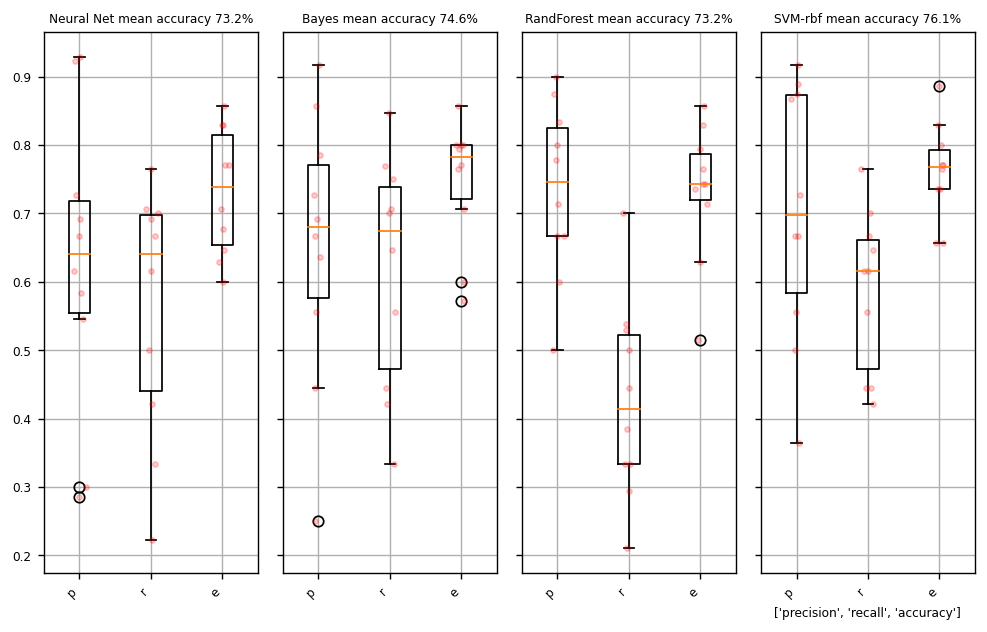

In [16]:
fig, axs = plt.subplots(1, len(models),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(models,  ['p','r','e'], fig, axs)
plt.xlabel(['precision', 'recall', 'accuracy'])
plt.show()

In [17]:
clf = SVC(kernel='rbf',class_weight='balanced',probability=True)

y = df['relevant']

clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

1336 out of 5774 documents are predicted to be relevant


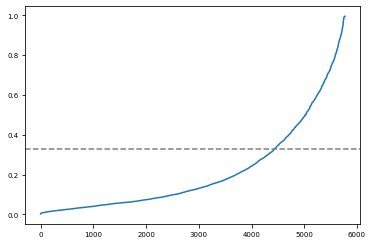

In [18]:
plt.close()

threshold = 0.33

df['0 - relevance - prediction'] = None
df.loc[unseen_index,'0 - relevance - prediction'] = y_pred[:,1]

predicted_index = df[df['0 - relevance - prediction']>threshold].index

fig, ax = plt.subplots()

pdf = df.sort_values('0 - relevance - prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['0 - relevance - prediction'])
ax.axhline(threshold,linestyle="--",color="grey")

rel = df[pdf['0 - relevance - prediction']>threshold].shape[0]
tot = pdf[pdf['0 - relevance - prediction'].notna()].shape[0]


print(f"{rel} out of {tot} documents are predicted to be relevant")

#df[['id','0 - relevance - prediction']].to_csv(f'predictions_{now}.csv',index=False)#removed doctables/ from dir

plt.show()

In [19]:
RelevantDocs  = df[(df['0 - relevance - prediction'] >= threshold) | (df['relevant'] == 1)]

RelevantDocs.shape

(1464, 14)

In [11]:
outdf = df[['id', 'relevant', 'seen', '0 - relevance - prediction']]
outdf.loc[outdf['seen'] ==0, 'relevant'] = None
outdf = outdf[['id', 'relevant', '0 - relevance - prediction']]
outdf.columns = ['id', 'label', 'prediction']

outdf.to_csv('pred.csv', index=False)
outdf

C:\Users\User\AppData\Local\Temp\ipykernel_9664\3666783576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outdf.loc[outdf['seen'] ==0, 'relevant'] = None


,id,label,prediction
0,17055,NaN,0.104286
1,15825,NaN,0.125885
2,15095,NaN,0.083126
3,17383,NaN,0.175548
4,13352,0.0,None
...,...,...,...
7662,15558,NaN,0.187323
7663,19845,NaN,0.079578
7664,18633,NaN,0.207201
7665,12873,1.0,None


In [14]:
df

,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen,1 - Earthquake,1 - Flood,1 - Hurricane,1 - Tsunami,y_k_prediction,0 - relevance - prediction
0,13263,"In the case of huge tsunamis, such as the 2004...",Rational Evaluation Methods of Topographical C...,2020.0,tsunami inundation simulation; topography chan...,FRAGILITY CURVES,0,1,0.0,0.0,0.0,0.0,0.478103,None
1,13538,The Banda Aceh city is located in an earthquak...,The prediction of building damages and casualt...,2018,None,None,0,0,0.0,0.0,0.0,0.0,NaN,0.151488
2,12626,This paper presents an original methodology fo...,Assessment of building damage due to excavatio...,2021.0,Risk assessment; Impact; Vulnerability; Buildi...,SEISMIC VULNERABILITY ASSESSMENT; GROUND SURFA...,0,1,0.0,0.0,0.0,0.0,0.216472,None
3,13264,The resilience of cities has received worldwid...,Real-time city-scale time-history analysis and...,2019,City-scale nonlinear time-history analysis; Gr...,None,0,0,0.0,0.0,0.0,0.0,NaN,0.439837
4,13374,"The seismic events in Northern Italy, May 2012...",Seismic fragility curves of single storey RC p...,2017,Beam-column connection collapse; RC precast st...,Building codes; Buildings; Codes (symbols); Ge...,0,0,0.0,0.0,0.0,0.0,NaN,0.769749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,13215,This paper presents probabilistic capacity mod...,Probabilistic capacity model and fragility est...,2018,Composite floor; column loss; progressive coll...,PROGRESSIVE COLLAPSE ANALYSIS; REINFORCED-CONC...,0,0,0.0,0.0,0.0,0.0,NaN,0.244679
1101,13406,This manuscript presents a comparative study b...,Seismic performance assessment of steel moment...,2017,Steel MRFs; Viscous damper; IDA; Far-field rec...,ENERGY-DISSIPATION; OPTIMAL-DESIGN; GROUND MOT...,0,0,0.0,0.0,0.0,0.0,NaN,0.118492
1102,13597,Existing heritage structures are frequently co...,Vulnerability Assessment of Monumental Masonry...,2019,Churches; Earthquake; Fragility curves; Monte ...,None,0,0,0.0,0.0,0.0,0.0,NaN,0.095037
1103,12735,The trend of adopting architectural designs wi...,Damage assessment of deficient reinforced conc...,2018,None,Concrete buildings; Developing countries; Rein...,0,0,0.0,0.0,0.0,0.0,NaN,0.407176


In [13]:
df['categories'] = df['1 - Earthquake'] + df['1 - Flood'] + df['1 - Hurricane'] + df['1 - Tsunami']
print("seen documents:",df.loc[df['seen']==1,].shape[0])
print("seen earthquake documents:", df.loc[df['seen']==1,'1 - Earthquake'].sum())
print("seen flood documents", df.loc[df['seen']==1,'1 - Flood'].sum())
print("seen hurricane documents", df.loc[df['seen']==1,'1 - Hurricane'].sum())
print("seen tsunami documents", df.loc[df['seen']==1,'1 - Tsunami'].sum())
print("seen in multiple", df.loc[df['categories']>=2,].shape[0])
print("seen non relevant documents",df.loc[(df['seen']==1) & (df['categories']==0),].shape[0])

seen documents: 347
seen earthquake documents: 84.0
seen flood documents 21.0
seen hurricane documents 8.0
seen tsunami documents 14.0
seen in multiple 0
seen non relevant documents 220


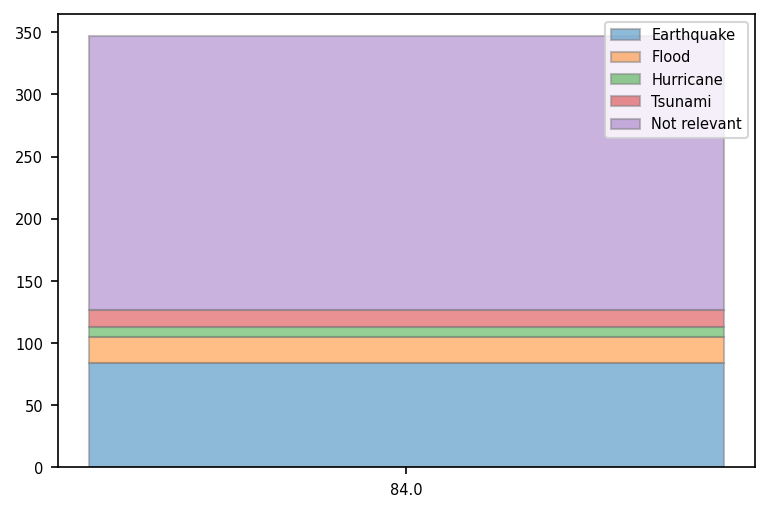

In [15]:
fig, ax = plt.subplots(dpi=150)

Earthquake = df.loc[df['seen']==1,'1 - Earthquake'].sum()
Flood = df.loc[df['seen']==1,'1 - Flood'].sum()
Hurricane = df.loc[df['seen']==1,'1 - Hurricane'].sum()
Tsunami = df.loc[df['seen']==1,'1 - Tsunami'].sum()
overlap = df.loc[df['categories']>=2,].shape[0]
nonrel = df.loc[(df['seen']==1) & (df['categories']==0),].shape[0]

lw = 1
alpha=0.5
ec = "grey"

ax.bar(
    0,Earthquake,
    alpha=alpha, label="Earthquake",
    lw=lw, edgecolor=ec, tick_label = str(Earthquake)
)
ax.bar(
    0,Flood,bottom=Earthquake-overlap/4,
    alpha=alpha, label="Flood",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,Hurricane,bottom=Earthquake-2*overlap/4+Flood ,
    alpha=alpha, label="Hurricane",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,Tsunami,bottom=Earthquake-3*overlap/4+Flood+Hurricane ,
    alpha=alpha, label="Tsunami",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,nonrel,bottom=Earthquake-overlap+Flood+Hurricane+Tsunami,
    alpha=alpha, label="Not relevant",
    lw=lw, edgecolor=ec,
)

ax.legend()

In [16]:
classes = ["1 - Earthquake","1 - Flood", "1 - Hurricane","1 - Tsunami"]
y = np.matrix(df[classes])
print(y.shape)

rel_index = df.loc[df["relevant"]==1,].index

(1105, 4)


In [17]:
from importlib import reload  
import learning_utils as lu

from sklearn.model_selection import KFold
multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels, metrics, df = lu.cross_validate_models(ab_X, y, multimodels, rel_index, classes=classes, df=df)


1


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

2


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tr

3


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tr

4


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tr

5


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

6


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tr

7


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tr

8


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tr

9


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

10


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tr

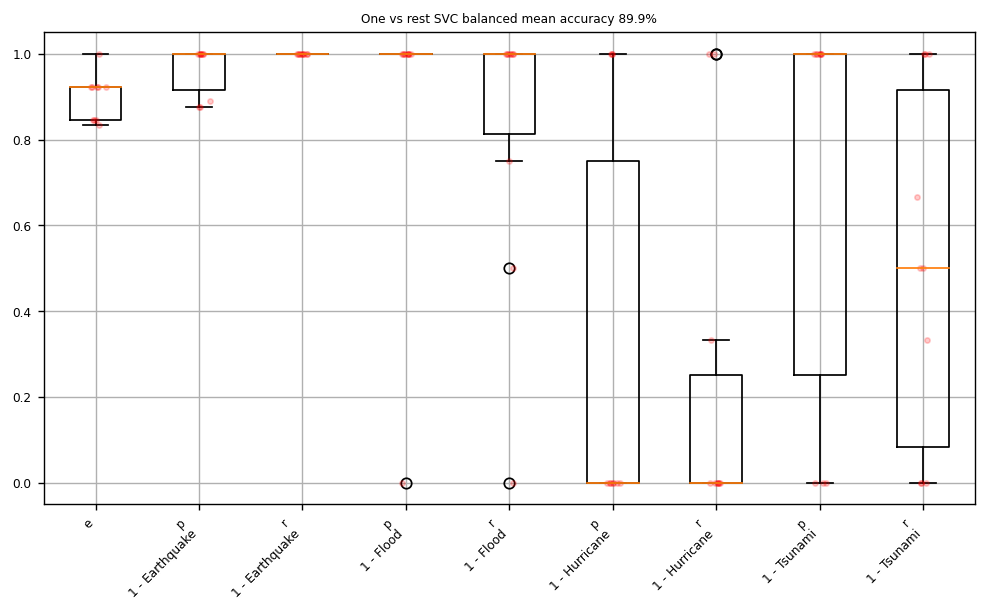

In [18]:
fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels, metrics, fig, [axs])
plt.show()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


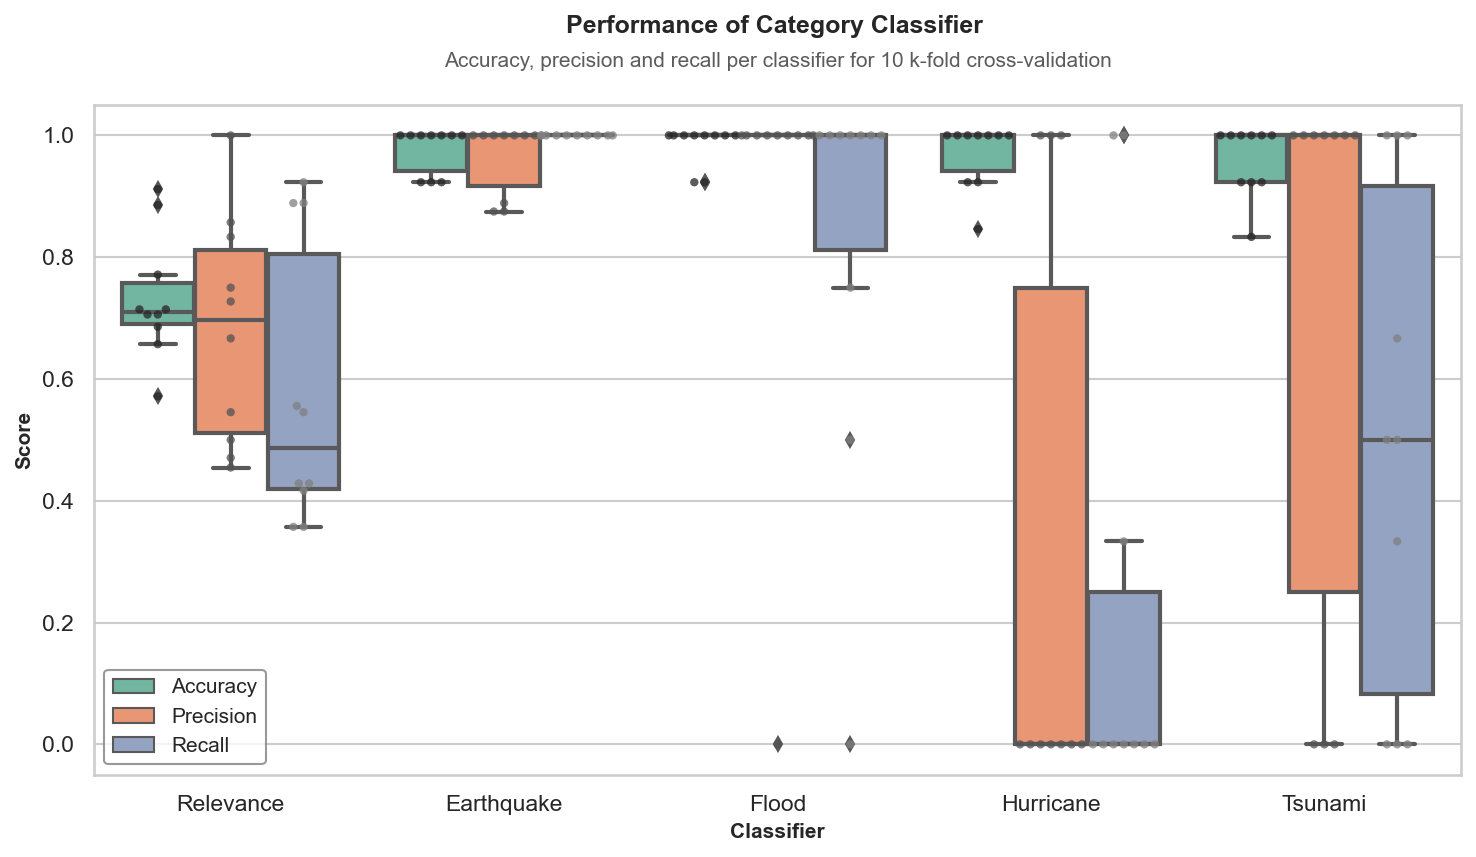

In [24]:
#With better formatting and the overall relevance included in one graph
import seaborn as sns

descriptives = [ #'e', 'p', 'r', 
                'e\n1 - Earthquake', 'p\n1 - Earthquake', 'r\n1 - Earthquake',
                'e\n1 - Flood', 'p\n1 - Flood', 'r\n1 - Flood',
                'e\n1 - Hurricane', 'p\n1 - Hurricane', 'r\n1 - Hurricane',
                'e\n1 - Tsunami', 'p\n1 - Tsunami', 'r\n1 - Tsunami'
               ]

boxplotdf = pd.DataFrame()
boxplotdf['Category'] = descriptives
gendf = pd.DataFrame({'Category' : ['e\n1 - Relevance', 'p\n1 - Relevance', 'r\n1 - Relevance']})

#get scores as list
boxplotdf['Scores'] = [multimodels[0][des] for des in boxplotdf['Category']]
gendf['Scores'] = [models[len(models)-1][des] for des in ['e', 'p', 'r']]

#merge the general and the multi-model
boxplotdf = pd.concat([gendf, boxplotdf], axis=0, ignore_index=True).reset_index()

#make a new row for each in list (basically: unfold the list to new variable, add new variable as column & drop old column)
s = boxplotdf.apply(lambda x: pd.Series(x['Scores']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Scores'
boxplotdf = boxplotdf.drop('Scores', axis=1).join(s)

#Get the category and the metric separately
new = boxplotdf["Category"].str.split("\n1 - ", n = 1, expand = True)
boxplotdf["Metric"]= new[0]
boxplotdf.drop(columns =["Category"], inplace = True) 
boxplotdf["Category"]= new[1] 

#rename
di = {'e': "Accuracy",
      'p': "Precision",
      'r': "Recall"}
boxplotdf.replace({"Metric": di}, inplace=True)

#plot 
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10,6),dpi=150)
ax = sns.boxplot(x="Category", y="Scores", hue="Metric",
                 data=boxplotdf, palette="Set2", linewidth = 2)

ax = sns.swarmplot(x="Category", y="Scores", hue="Metric", dodge=True, #add points
                   data=boxplotdf, color="grey", alpha = 0.75, size=4
                  ) 


ax.set_ylabel('Score', fontsize = 10, weight = 'bold')
ax.set_xlabel('Classifier', fontsize = 10, weight = 'bold')

title = 'Performance of Category Classifier '
subtitle = 'Accuracy, precision and recall per classifier for 10 k-fold cross-validation'
ax.text(x=0.5, y=1.1, s=title, fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s=subtitle, fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

handles, labels = ax.get_legend_handles_labels()
#l = plt.legend()
ax.legend(handles[0:3], labels[0:3],
          fontsize=10, title_fontsize='10', loc = 'lower left',
          facecolor = 'white', edgecolor='grey')


fig.tight_layout(rect=[0, 0, 1, 0.98])
fig.savefig(f'{title}_{subtitle}.png')



['1 - Earthquake - k_prediction_binary', '1 - Flood - k_prediction_binary', '1 - Hurricane - k_prediction_binary', '1 - Tsunami - k_prediction_binary']


<bound method Figure.show of <Figure size 1000x1000 with 2 Axes>>

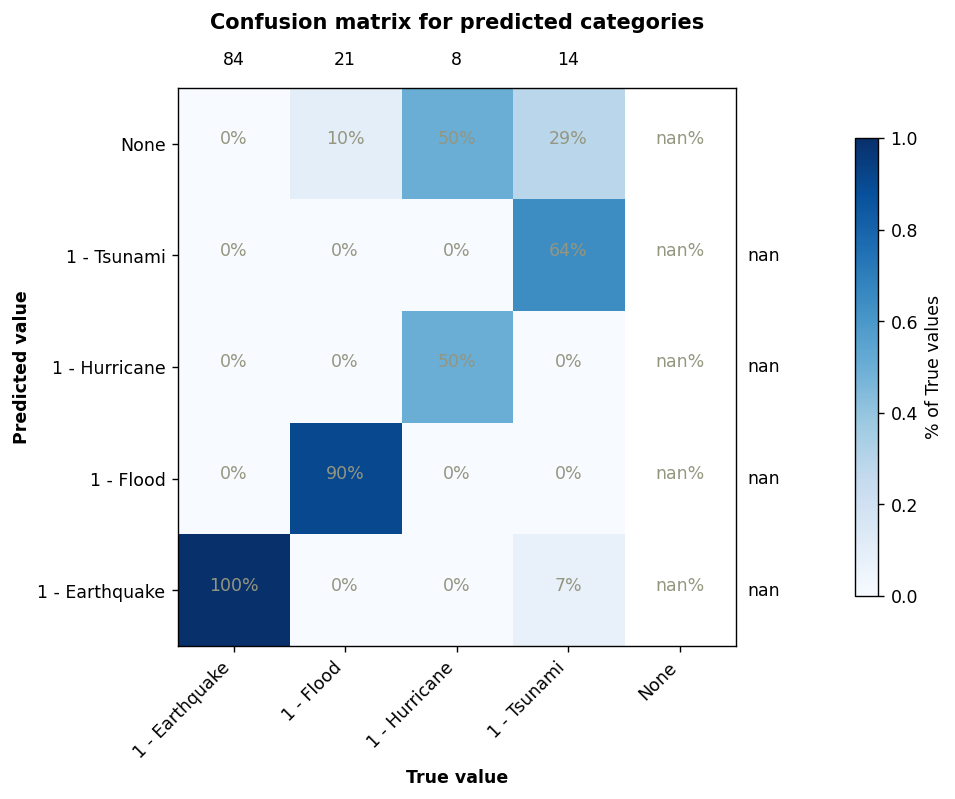

In [25]:
sns.reset_defaults()
classes = ["1 - Earthquake","1 - Flood", "1 - Hurricane","1 - Tsunami"]
cols = [f"{c} - k_prediction_binary" for c in classes]
print(cols)
y_pred = np.array(list(df.loc[seen_index,cols].values))
   
y_true = y[seen_index]

confusion_matrix = np.zeros(shape=(len(classes)+1,len(classes)+1),dtype=float)

norm = True

for j, c in enumerate(classes): #rows
    for k, c in enumerate(classes): #cols
        n = 0
        for i in range(len(seen_index)):
            if j==k:
                if y_true[i,j]+y_pred[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1/y_pred[i,].sum()
        confusion_matrix[j,k]=n
        
    sums_pred = y_pred.sum(axis=1).ravel()
    confusion_matrix[k+1,j]=y_true[np.argwhere(sums_pred==0).ravel(),j].sum()
    sums_true = y_true.sum(axis=1).ravel()
    confusion_matrix[j,k+1]=y_pred[np.argwhere(sums_true==0).ravel(),j].sum()
    confusion_matrix[j+1,k+1] = y_pred[np.argwhere(sums_true+sums_pred==0)].shape[0]


if norm is not False:
    confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=0,keepdims=True)


fig, ax = plt.subplots(dpi=125, figsize=(8,8))


if norm is not False:
    mat = ax.imshow(confusion_matrix, cmap="Blues", vmin=0, vmax=1, origin="lower")
else:
    mat = ax.imshow(confusion_matrix, cmap="Blues",origin="lower")
    
classes = classes + ["None"]
for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n  = confusion_matrix[j,k]
        if n > np.max(confusion_matrix)/2:
            color="#d9d9d9"
        else:
            color="#949680"
        if norm is not False:
            ax.text(k,j, f"{confusion_matrix[j,k]:.0%}",ha="center",color=color)
        else:
            ax.text(k,j, f"{confusion_matrix[j,k]:.1f}",ha="center",color=color)

    if j < len(classes)-1:    
        ax.text(j,len(classes)-0.25,f"{y_true[:,j].sum():,.0f}",ha="center",va="center")
        ax.text(len(classes)-0.25, j, f"{y_pred[:,j].sum():,.0f}",ha="center",va="center")
        
ax.set_xticks(list(range(len(classes))))
ax.set_xticklabels([x.replace("12 - ","") for x in classes],rotation=45,ha="right")

ax.set_yticks(list(range(len(classes))))
ax.set_yticklabels([x.replace("12 - ","") for x in classes],ha="right")
ax.set_xlabel("True value", fontsize = 10, weight = 'bold')
ax.set_ylabel("Predicted value", fontsize = 10, weight = 'bold')

#ax.set_xlim(xmax=len(classes)+1)

cbar = fig.colorbar(mat, ax=ax, pad=0.15, shrink = 0.5)
if norm is not False:
    cbar.set_label("% of True values")
    
title = "Confusion matrix for predicted categories"
ax.text(x=0.5, y=1.1, s=title, fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)

fig.tight_layout(rect=[0, 0, 1, 0.98])
fig.savefig(f'confusion_matrix.png')
fig.show

In [27]:
model_df = pd.DataFrame(multimodels)

predicted_index = df[df['0 - relevance - prediction']>0.33].index
LabeledRelevant_index = df[df['relevant']==1].index

clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
classes = ["1 - Earthquake","1 - Flood", "1 - Hurricane","1 - Tsunami"]
y = np.matrix(df[classes])
y.shape

clf.fit(ab_X[seen_index],y[seen_index]) #fit on the labeled as relevant data
predictions = clf.predict_proba(ab_X[predicted_index]) #get probability scores for those predicted to be relevant
binary = clf.predict(ab_X[predicted_index]) #get binary scores too

#Add predictions to the dataframe or nan if no prediction
for i,c in enumerate(classes):
    df[f"{c} - prediction"] = np.NaN
    
    df.loc[predicted_index, f"{c} - prediction"] = predictions[:, i]
    
#Check
print(df[df['1 - Earthquake - prediction'] > .1].shape)
df[df['1 - Earthquake - prediction'] > .1].head(20)

df.to_csv('predFin.csv', index=False)

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

(196, 27)
